# 1. Importing Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from PIL import Image
import PIL
import os
import glob

from keras.models import Sequential, load_model
from keras.layers import BatchNormalization, ConvLSTM2D, Conv3D, Conv2D, TimeDistributed
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import keras.backend as K

from skimage import img_as_float
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import mean_squared_error as MSE

# 2. Bundling Images Into one Single Object

In [ ]:
# Resize images in a fixed aspect ratio
fixed_width = 490
# image = Image.open('../input/mortality-rates/400.jpeg')
# image = Image.open('../input/infection-rates/400.jpeg')
image = Image.open('../input/krighed-mortality-rates/400.jpeg')
width_percent = (fixed_width / float(image.size[0]))
height_size = int((float(image.size[1]) * float(width_percent)))
image = image.resize((fixed_width, height_size), PIL.Image.NEAREST)
image.size

In [ ]:
# img_dir = "../input/mortality-rates/"  # Enter directory of all images
# img_dir = "../input/infection-rates/"
img_dir = "../input/krighed-mortality-rates/"
data_path = os.path.join(img_dir,'*jpeg')
files = glob.glob(data_path)
files.sort()

data = []
for f1 in files:
    img = Image.open(f1)
    data.append(np.asarray(img.resize(image.size)))

# 3. Converting Images Into Numpy Arrays

In [ ]:
data = img_as_float(np.array(data))
data.shape

# Pickling file
# pickle_out = open('data.pickle', 'wb')
# pickle.dump(data, pickle_out)
# pickle_out.close()

# Reading in the pickled file
# pickle_in = open('./data.pickle', 'rb')
# data = pickle.load(pickle_in)

In [ ]:
# Displayig an image
figure(figsize=(5, 5))
plt.imshow(data[444])
plt.show()

# 4. Prepairing Input to Networks

In [ ]:
X = []
for i in range(0,435):  # data.shape[0]-9
    X.append(data[i : i + 11,:,:,:])

X = np.array(X)
X.shape

# Split into train and test sets.
train_data, test_data = np.split(X, [int(.70 *len(X))])

# Inspect the dataset.
print("Training Dataset Shape is: " + str(train_data.shape))
print("Testing Dataset Shape is: " + str(test_data.shape))

In [ ]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_data)
x_test, y_test = create_shifted_frames(test_data)


# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Testing Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

In [ ]:
# Using memory mapping to address memory usage problems
mm1 = np.memmap('x_train', dtype='float32', mode='w+', shape=x_train.shape)
mm2 = np.memmap('y_train', dtype='float32', mode='w+', shape=y_train.shape)
mm3 = np.memmap('x_test', dtype='float32', mode='w+', shape=x_test.shape)
mm4 = np.memmap('y_test', dtype='float32', mode='w+', shape=y_test.shape)

mm1[:,:,:,:,:] = x_train[:,:,:,:,:]
mm2[:,:,:,:,:] = y_train[:,:,:,:,:]
mm3[:,:,:,:,:] = x_test[:,:,:,:,:]
mm4[:,:,:,:,:] = y_test[:,:,:,:,:]

# Now restart and clear cell outputs

In [2]:
# Reading in mapped files
# Import packages again
x_train = np.memmap('./x_train', dtype='float32', mode='r', shape=(304, 10, 212, 490, 3))
y_train = np.memmap('./y_train', dtype='float32', mode='r', shape=(304, 10, 212, 490, 3))
x_test = np.memmap('./x_test', dtype='float32', mode='r', shape=(131, 10, 212, 490, 3))
y_test = np.memmap('./y_test', dtype='float32', mode='r', shape=(131, 10, 212, 490, 3))

# 5.1 Time-Distributed Model Building

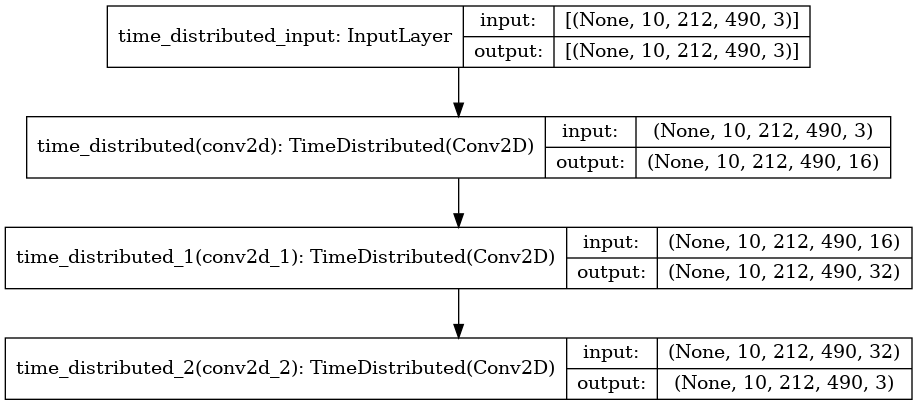

In [3]:
"""
## Model Construction
To build a Time-distributed CNN model, we will use the
`TimeDistributed` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.
"""

# Clearing model session
K.clear_session()

model1 = Sequential()
model1.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape = x_train.shape[1:]))
model1.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model1.add(TimeDistributed(Conv2D(3, (3,3), padding='same', activation='relu')))

# Plotting graph
plot_model(model1, to_file='Time-distributed Neural Network.png', show_shapes=True, rankdir='TB')

In [4]:
# Freeing up memory which is no longer in use.
import gc
gc.collect()

optimizer = Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=optimizer)

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 212, 490, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 212, 490, 32)  4640      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 212, 490, 3)   867       
Total params: 5,955
Trainable params: 5,955
Non-trainable params: 0
_________________________________________________________________


# 5.2 Time-Distributed Model Training

In [5]:
# Freeing up memory which is no longer in use.
import gc
gc.collect()

"""
## Model Training
With our model and data constructed, we can now train the model.
"""

EarlyStopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='min')

epochs = 50
batch_size = 8

history = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,
                     callbacks=[EarlyStopper], verbose=1)

Epoch 1/50
31/31 [==============================] - 103s 3s/step - loss: 0.3629 - val_loss: 0.0224
Epoch 2/50
31/31 [==============================] - 10s 334ms/step - loss: 0.0173 - val_loss: 0.0095
Epoch 3/50
31/31 [==============================] - 10s 322ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 4/50
31/31 [==============================] - 10s 318ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 5/50
31/31 [==============================] - 10s 326ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/50
31/31 [==============================] - 10s 338ms/step - loss: 7.3585e-04 - val_loss: 8.0379e-04
Epoch 7/50
31/31 [==============================] - 10s 321ms/step - loss: 5.3366e-04 - val_loss: 6.7523e-04
Epoch 8/50
31/31 [==============================] - 9s 306ms/step - loss: 4.8211e-04 - val_loss: 5.3822e-04
Epoch 9/50
31/31 [==============================] - 10s 325ms/step - loss: 4.0444e-04 - val_loss: 4.6596e-04
Epoch 10/50
31/31 [==============================] - 10s 318ms

# 5.3 Inspecting Time-Distributed Model Loss

In [6]:
epochs = len(history.epoch) + 1

def plot_loss(history):
  figure(figsize=(9, 5))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.autoscale(enable=True, axis='x', tight=True)
  plt.xticks(np.arange(0, epochs, 2.0))
  plt.xlabel('Epoch')
  plt.ylabel('Error (MSE)')
  plt.legend(fontsize=10)

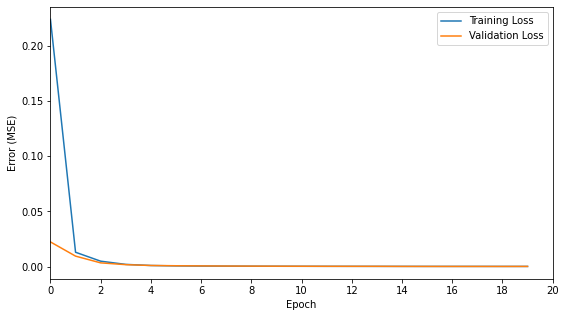

In [7]:
plot_loss(history)

# 5.4 Time-Distributed Model Prediction

In [77]:
"""
## Frame Prediction Visualizations
With our model now constructed and trained, we can generate
some example frame predictions based on a new video.
"""

# For predicting into future
last_frames = y_test[130,:, ...]
last_frames = np.expand_dims(last_frames, axis=0)
print("last_frames shape: " + str(last_frames.shape))

last_frames shape: (1, 10, 212, 490, 3)


In [78]:
pred1 = model1.predict(last_frames)  # The last frame of this batch is the prediction for the day 445
pred2 = model1.predict(pred1)          # The last frame of this batch is the prediction for the day 446
pred3 = model1.predict(pred2)          # The last frame of this batch is the prediction for the day 447
pred4 = model1.predict(pred3)          # The last frame of this batch is the prediction for the day 448
pred5 = model1.predict(pred4)          # The last frame of this batch is the prediction for the day 449
pred6 = model1.predict(pred5)          # The last frame of this batch is the prediction for the day 450

print("pred1 shape: " + str(pred1.shape))
print("pred2 shape: " + str(pred2.shape))
print("pred3 shape: " + str(pred3.shape))
print("pred4 shape: " + str(pred4.shape))
print("pred5 shape: " + str(pred5.shape))
print("pred6 shape: " + str(pred6.shape))

# Extend the set of prediction frames.
preds1 = np.concatenate((pred2, pred3, pred4, pred5, pred6), axis=1)
print("preds1: " + str(preds1.shape))

pred1 shape: (1, 10, 212, 490, 3)
pred2 shape: (1, 10, 212, 490, 3)
pred3 shape: (1, 10, 212, 490, 3)
pred4 shape: (1, 10, 212, 490, 3)
pred5 shape: (1, 10, 212, 490, 3)
pred6 shape: (1, 10, 212, 490, 3)
preds1: (1, 50, 212, 490, 3)


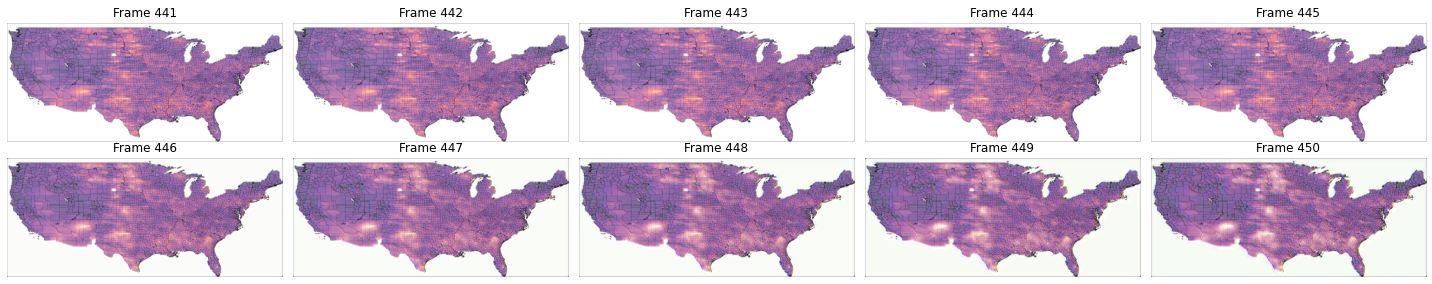

In [79]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))

# Plot the last five frames of x_test[130].
our_frames = last_frames[0,5:, ...]
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(our_frames[idx]))
    ax.set_title(f"Frame {idx + 441}")
    ax.axis("off")


# Plot the new frames.
new_frames = preds1[0, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[(idx*10)+9]))
    ax.set_title(f"Frame {idx + 446}")
    ax.axis("off")

plt.savefig('fig1.png', dpi=150, format='png')
plt.tight_layout()

# Display the figure.
plt.show()

# 5.5 Time-Distributed Model Evaluation

In [80]:
# Evaluating on test set
model1.evaluate(x_test, y_test)

5/5 [==============================] - 3s 361ms/step - loss: 2.3445e-04


0.00023444832186214626

In [15]:
pred = model1.predict(x_test)

# Calculating the mean of mse and ssim for all paired test and predicted images
ssim_values = []
mse_values = []
ssim_means = []
mse_means = []

for j in range(131):
    for i in range(10):
        ssim_values.append(round(SSIM(y_test[j][i], pred[j][i], multichannel=True,
                                      gaussian_weights=True, sigma=1.5, use_sample_covariance=False),5))
        mse_values.append(round(MSE(y_test[j][i], pred[j][i]),5))

for i in range(0, len(ssim_values), 10):
    ssim_means.append(np.mean(ssim_values[i:i + 10]))

for i in range(0, len(mse_values), 10):
    mse_means.append(np.mean(mse_values[i:i + 10]))
    
print('The mean of all averaged ssim values is:', round(np.mean(ssim_means),5))
print('The mean of all averaged mse values is:', round(np.mean(mse_means),5))

# Checking the ssim and mse of the last instance of test set
print("*************************************")
print("The SSIM for 1st frame is: " + str(round(SSIM(y_test[130][0], pred[130][0], multichannel=True),5)),
      "\nThe SSIM for 2nd frame is: " + str(round(SSIM(y_test[130][1], pred[130][1], multichannel=True),5)),
      "\nThe SSIM for 3rd frame is: " + str(round(SSIM(y_test[130][2], pred[130][2], multichannel=True),5)),
      "\nThe SSIM for 4th frame is: " + str(round(SSIM(y_test[130][3], pred[130][3], multichannel=True),5)),
      "\nThe SSIM for 5th frame is: " + str(round(SSIM(y_test[130][4], pred[130][4], multichannel=True),5)),
      "\nThe SSIM for 6th frame is: " + str(round(SSIM(y_test[130][5], pred[130][5], multichannel=True),5)),
      "\nThe SSIM for 7th frame is: " + str(round(SSIM(y_test[130][6], pred[130][6], multichannel=True),5)),
      "\nThe SSIM for 8th frame is: " + str(round(SSIM(y_test[130][7], pred[130][7], multichannel=True),5)),
      "\nThe SSIM for 9th frame is: " + str(round(SSIM(y_test[130][8], pred[130][8], multichannel=True),5)),
      "\nThe SSIM for 10th frame is: " + str(round(SSIM(y_test[130][9], pred[130][9], multichannel=True),5)))
print("*************************************")
print("The MSE for 1st frame is: " + str(round(MSE(y_test[130][0],pred[130][0]),5)),
      "\nThe MSE for 2nd frame is: " + str(round(MSE(y_test[130][1],pred[130][1]),5)),
      "\nThe MSE for 3rd frame is: " + str(round(MSE(y_test[130][2],pred[130][2]),5)),
      "\nThe MSE for 4th frame is: " + str(round(MSE(y_test[130][3],pred[130][3]),5)),
      "\nThe MSE for 5th frame is: " + str(round(MSE(y_test[130][4],pred[130][4]),5)),
      "\nThe MSE for 6th frame is: " + str(round(MSE(y_test[130][5],pred[130][5]),5)),
      "\nThe MSE for 7th frame is: " + str(round(MSE(y_test[130][6],pred[130][6]),5)),
      "\nThe MSE for 8th frame is: " + str(round(MSE(y_test[130][7],pred[130][7]),5)),
      "\nThe MSE for 9th frame is: " + str(round(MSE(y_test[130][8],pred[130][8]),5)),
      "\nThe MSE for 10th frame is: " + str(round(MSE(y_test[130][9],pred[130][9]),5)),)

The mean of all averaged ssim values is: 0.99031
The mean of all averaged mse values is: 0.00023
*************************************
The SSIM for 1st frame is: 0.99001 
The SSIM for 2nd frame is: 0.98995 
The SSIM for 3rd frame is: 0.99021 
The SSIM for 4th frame is: 0.99016 
The SSIM for 5th frame is: 0.99003 
The SSIM for 6th frame is: 0.99002 
The SSIM for 7th frame is: 0.98995 
The SSIM for 8th frame is: 0.98997 
The SSIM for 9th frame is: 0.99003 
The SSIM for 10th frame is: 0.99016
*************************************
The MSE for 1st frame is: 0.00023 
The MSE for 2nd frame is: 0.00023 
The MSE for 3rd frame is: 0.00023 
The MSE for 4th frame is: 0.00023 
The MSE for 5th frame is: 0.00023 
The MSE for 6th frame is: 0.00023 
The MSE for 7th frame is: 0.00024 
The MSE for 8th frame is: 0.00023 
The MSE for 9th frame is: 0.00023 
The MSE for 10th frame is: 0.00023


# 6.1 ConvLSTM Model Building

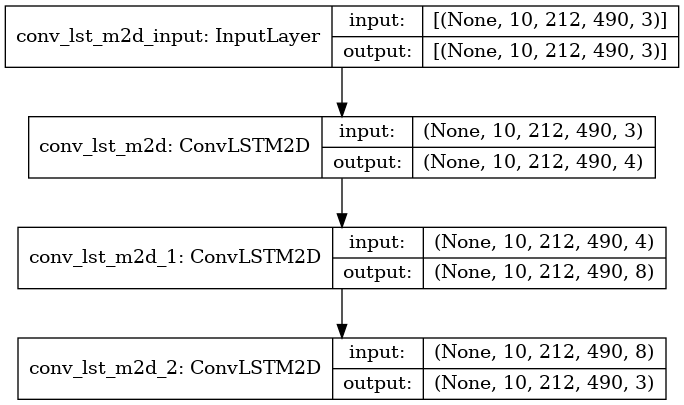

In [16]:
"""
## Model Construction
To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.
"""

# Clearing model session
K.clear_session()

model2 = Sequential()
model2.add(ConvLSTM2D(input_shape=x_train.shape[1:], filters=4, kernel_size=(3, 3), padding="same",
                     return_sequences=True, activation="relu"))

model2.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), padding="same", return_sequences=True,
                     activation="relu"))

model2.add(ConvLSTM2D(filters=3, kernel_size=(3, 3), padding="same", return_sequences=True,
                     activation="relu"))

# model2.add(BatchNormalization())
# model2.add(Conv2D(filters=3, kernel_size=(3, 3), padding="same", activation='relu'))

# model2.add(BatchNormalization())
# model2.add(Conv3D(filters=3, kernel_size=(3, 3, 3), activation="relu", padding="same"))

# Plotting graph
plot_model(model2, to_file='ConvLSTM Neural Network.png', show_shapes=True, rankdir='TB')

In [17]:
optimizer = Adam(learning_rate=0.001)
model2.compile(loss='mean_squared_error', optimizer=optimizer)

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 10, 212, 490, 4)   1024      
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 212, 490, 8)   3488      
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 212, 490, 3)   1200      
Total params: 5,712
Trainable params: 5,712
Non-trainable params: 0
_________________________________________________________________


# 6.2 ConvLSTM Model Training

In [18]:
# Freeing up memory which is no longer in use.
import gc
gc.collect()

"""
## Model Training
With our model and data constructed, we can now train the model.
"""

# Define some callbacks to improve training.
EarlyStopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='min')

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 8

# Fit the model to the training data.
history = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,
                     callbacks=[EarlyStopper], verbose=1)

Epoch 1/50
31/31 [==============================] - 51s 1s/step - loss: 0.4661 - val_loss: 0.2277
Epoch 2/50
31/31 [==============================] - 43s 1s/step - loss: 0.1761 - val_loss: 0.0910
Epoch 3/50
31/31 [==============================] - 31s 1s/step - loss: 0.0680 - val_loss: 0.0321
Epoch 4/50
31/31 [==============================] - 31s 1s/step - loss: 0.0220 - val_loss: 0.0136
Epoch 5/50
31/31 [==============================] - 31s 1s/step - loss: 0.0121 - val_loss: 0.0120
Epoch 6/50
31/31 [==============================] - 31s 1s/step - loss: 0.0108 - val_loss: 0.0110
Epoch 7/50
31/31 [==============================] - 31s 1s/step - loss: 0.0099 - val_loss: 0.0102
Epoch 8/50
31/31 [==============================] - 32s 1s/step - loss: 0.0092 - val_loss: 0.0094
Epoch 9/50
31/31 [==============================] - 31s 1s/step - loss: 0.0085 - val_loss: 0.0088
Epoch 10/50
31/31 [==============================] - 31s 1s/step - loss: 0.0079 - val_loss: 0.0080
Epoch 11/50
31/31 [

# 6.3 Inspecting ConvLSTM Model Loss

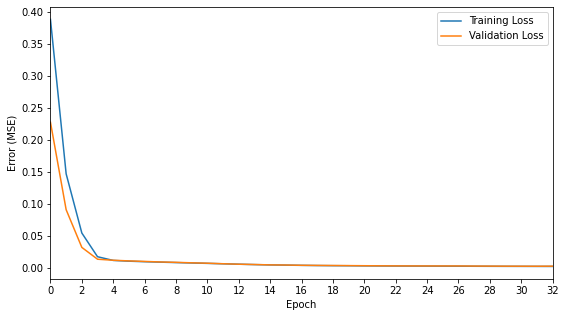

In [19]:
epochs = len(history.epoch) + 1
plot_loss(history)

# 6.4 ConvLSTM Model Prediction

In [110]:
"""
## Frame Prediction Visualizations
With our model now constructed and trained, we can generate
some example frame predictions based on a new video.
We'll pick an example from the test set and
then choose the first five frames from them. From there, we can
allow the model to predict 5 new frames, which we can compare
to the ground truth frame predictions.
"""

# Pick the first/last five frames from the example.
frames = x_test[130,:5, ...]
original_frames = x_test[130,5:, ...]

frames = np.squeeze(frames)
original_frames = np.squeeze(original_frames)

print("frames shape: " + str(frames.shape))
print("original_frames shape: " + str(original_frames.shape))

# For predicting into future
last_frames = y_test[130,:, ...]
last_frames_copy = last_frames
last_frames = np.squeeze(last_frames)
print("last_frames shape: " + str(last_frames.shape))

frames shape: (5, 212, 490, 3)
original_frames shape: (5, 212, 490, 3)
last_frames shape: (10, 212, 490, 3)


In [111]:
# Predict a new set of 5 frames.
for _ in range(5):
    # Extract the model's prediction and post-process it.
    new_prediction = model2.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
    
frames.shape

(10, 212, 490, 3)

In [112]:
# Predict a new set of 5 frames into future.
for _ in range(5):
    # Extract the model's prediction and post-process it.
    new_prediction = model2.predict(np.expand_dims(last_frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    last_frames = np.concatenate((last_frames, predicted_frame), axis=0)
    
last_frames.shape

(15, 212, 490, 3)

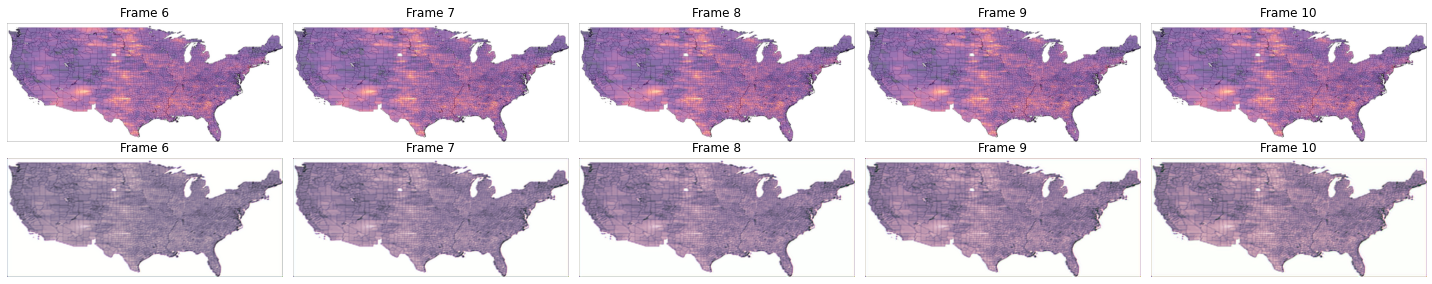

In [90]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]))
    ax.set_title(f"Frame {idx + 6}")
    ax.axis("off")

    
# Plot the new frames.
new_frames = frames[5:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]))
    ax.set_title(f"Frame {idx + 6}")
    ax.axis("off")

plt.savefig('fig2_1.png', dpi=150, format='png')
plt.tight_layout()

# Display the figure.
plt.show()

In [91]:
print("*************************************")
print("The SSIM for 1st frame is: " + str(round(SSIM(original_frames[0], new_frames[0], multichannel=True),5)),
      "\nThe SSIM for 2nd frame is: " + str(round(SSIM(original_frames[1], new_frames[1], multichannel=True),5)),
      "\nThe SSIM for 3rd frame is: " + str(round(SSIM(original_frames[2], new_frames[2], multichannel=True),5)),
      "\nThe SSIM for 4th frame is: " + str(round(SSIM(original_frames[3], new_frames[3], multichannel=True),5)),
      "\nThe SSIM for 5th frame is: " + str(round(SSIM(original_frames[4], new_frames[4], multichannel=True),5)))
print("*************************************")
print("The MSE for 1st frame is: " + str(round(MSE(original_frames[0],new_frames[0]),5)),
      "\nThe MSE for 2nd frame is: " + str(round(MSE(original_frames[1],new_frames[1]),5)),
      "\nThe MSE for 3rd frame is: " + str(round(MSE(original_frames[2],new_frames[2]),5)),
      "\nThe MSE for 4th frame is: " + str(round(MSE(original_frames[3],new_frames[3]),5)),
      "\nThe MSE for 5th frame is: " + str(round(MSE(original_frames[4],new_frames[4]),5)))

*************************************
The SSIM for 1st frame is: 0.88458 
The SSIM for 2nd frame is: 0.89179 
The SSIM for 3rd frame is: 0.89584 
The SSIM for 4th frame is: 0.89809 
The SSIM for 5th frame is: 0.89803
*************************************
The MSE for 1st frame is: 0.00362 
The MSE for 2nd frame is: 0.00313 
The MSE for 3rd frame is: 0.00288 
The MSE for 4th frame is: 0.00285 
The MSE for 5th frame is: 0.0031


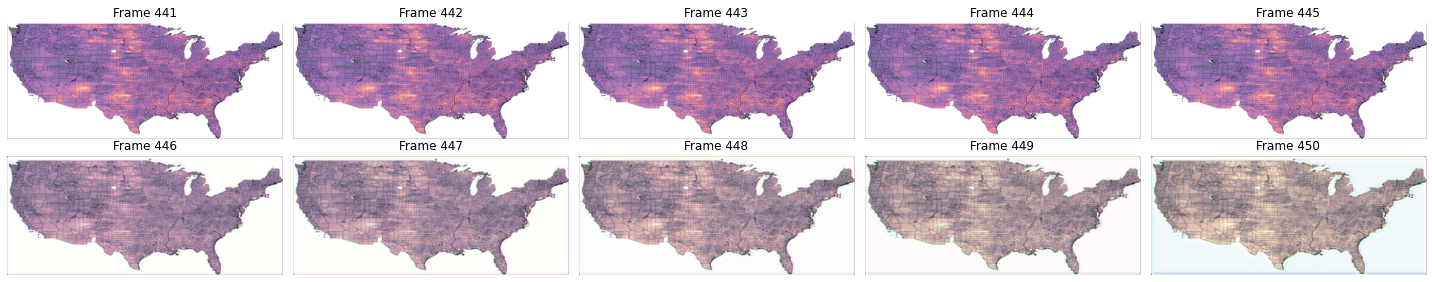

In [116]:
# Construct a figure for the original and future frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))

# Plot the last five frames of x_test[130].
our_frames = last_frames_copy[:,5:, ...]
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(our_frames[idx]))
    ax.set_title(f"Frame {idx + 441}")
    ax.axis("off")

    
# Plot the new frames.
new_frames = last_frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]))
    ax.set_title(f"Frame {idx + 446}")
    ax.axis("off")

plt.savefig('fig2_2.png', dpi=150, format='png')
plt.tight_layout()

# Display the figure.
plt.show()

# 6.5 ConvLSTM Model Evaluation

In [26]:
# Evaluating on test set
model2.evaluate(x_test, y_test)

5/5 [==============================] - 32s 5s/step - loss: 0.0036


0.003596897004172206

In [27]:
pred = model2.predict(x_test)

# Calculating the mean of mse and ssim for all paired test and predicted images
ssim_values = []
mse_values = []
ssim_means = []
mse_means = []

for j in range(131):
    for i in range(10):
        ssim_values.append(round(SSIM(y_test[j][i], pred[j][i], multichannel=True,
                                      gaussian_weights=True, sigma=1.5, use_sample_covariance=False),5))
        mse_values.append(round(MSE(y_test[j][i], pred[j][i]),5))

for i in range(0, len(ssim_values), 10):
    ssim_means.append(np.mean(ssim_values[i:i + 10]))

for i in range(0, len(mse_values), 10):
    mse_means.append(np.mean(mse_values[i:i + 10]))
    
print('The mean of all averaged ssim values is:', round(np.mean(ssim_means),5))
print('The mean of all averaged mse values is:', round(np.mean(mse_means),5))

The mean of all averaged ssim values is: 0.87149
The mean of all averaged mse values is: 0.0036


# 7. Saving Model

In [117]:
model1.save('COVID19_TimeDist_Modeling_KM.h5')
model2.save('COVID19_ConvLSTM_Modeling_KM.h5')

# 8. Loading Model

In [119]:
Model_TimeDist = load_model('COVID19_TimeDist_Modeling_KM.h5')
Model_ConvLSTM = load_model('COVID19_ConvLSTM_Modeling_KM.h5')

print('ConvLSTM Model:')
print(Model_ConvLSTM.summary())
print("\n******************************************************************\n")
print('Time-Distributed CNN Model:')
print(Model_TimeDist.summary())

ConvLSTM Model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 212, 490, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 212, 490, 32)  4640      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 212, 490, 3)   867       
Total params: 5,955
Trainable params: 5,955
Non-trainable params: 0
_________________________________________________________________
None

******************************************************************

Time-Distributed CNN Model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 10, 212, 490, 4)   1024      
________________________________________________